***
[16 November 2018] FE mask offsets and M1 lateral
### Abstract:
Testing a method to orient the front end movable mask (mm1x,mm2x,mm1y,mm2y) to the beam, so that we can set a gap and know that it is centered on the beam axis.

Followed by testing a method to determine the correct M1 lateral position.

Still unclear whether these methods are the best way to achieve what we want.

All of this was done with an EPU gap of 40mm, phase 0. moveable mask y-axes closed as far as possible.

***

In [1]:
from BLOCH_beamline import *
data_folder = Path('Data/')

%matplotlib inline
font = {'size'   : 14}
matplotlib.rc('font', **font)

---- BLOCH beamline ----
	Last updated 27.11.2018 

	Latest change: better HDF5 handling



***
### Finding where mm_1x, mm_2x cut into the beam

A plate facing the M1 surface collects photoelectrons emitted from the mirror. It (should?) give an estimate of the total flux on the mirror.

If we measure this current while closing one side of the front end, what should we see? If we start with the mask open wider than the beam, closing it will have no effect until the mask starts cutting into the beam. So this kind of a sweep should look like a flat section up to some edge, then a linear decrease as we start reducing the beam footprint on the mirror.

<img src="images/m1_3.png" width="300px"/>

There is an extra complication here: If the M1 mirror is overilluminated by the un-cut beam, the edge we measure will not correspond to the edge of the beam. We need to drive in even further before the footprint starts to reduce.

<img src="images/m1_4.png" width="300px"/>

To make sure that the edge/knee in the mm_1x sweep corresponds to the edge of the beam, we should take several measurements at different M1 lateral positions, trying to move the mirror out of the un-cut beam so that it is not overilluminated. When the knee position in the mm1_x scans stops changing with M1 lateral, the knee must correspond to cutting the beam

In [4]:
def loadScan(entryNumber):
    scan = HDF5loadscan(data_folder/"feM1test1.h5",entryNumber)
    scan['drainCurrent'] = [((ii*-1)/1000) for ii in scan['b110a_ctl_em01_ch01']]
    return scan

In [5]:
scanSet=[]
scanSet.append(loadScan(2496))
print("Entry 2496: M1 lateral=",scanSet[-1]['m1_lateralposition'][0])
scanSet.append(loadScan(2497))
print("Entry 2497: M1 lateral=",scanSet[-1]['m1_lateralposition'][0])
scanSet.append(loadScan(2498))
print("Entry 2498: M1 lateral=",scanSet[-1]['m1_lateralposition'][0])
scanSet.append(loadScan(2499))
print("Entry 2499: M1 lateral=",scanSet[-1]['m1_lateralposition'][0])

Entry 2496: M1 lateral= -400.04604632294934
Entry 2497: M1 lateral= 3599.9989533844846
Entry 2498: M1 lateral= 4000.038453334331
Entry 2499: M1 lateral= 4499.953953443001


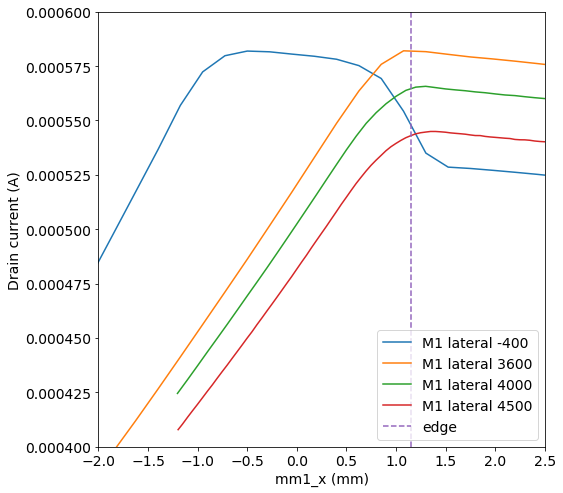

In [6]:
fig=plt.figure(figsize=[8,8])
plt.plot(scanSet[0]['mm1_x'],scanSet[0]['drainCurrent'],label='M1 lateral -400')
plt.plot(scanSet[1]['mm1_x'],scanSet[1]['drainCurrent'],label='M1 lateral 3600')
plt.plot(scanSet[2]['mm1_x'],scanSet[2]['drainCurrent'],label='M1 lateral 4000')
plt.plot(scanSet[3]['mm1_x'],scanSet[3]['drainCurrent'],label='M1 lateral 4500')
knee_x = 1.15
plt.plot([knee_x,knee_x],[40e-5,60e-5],linestyle='--',label='edge')
plt.ylabel('Drain current (A)')
plt.xlabel('mm1_x (mm)')
plt.xlim([-2,2.5])
plt.ylim([40e-5,60e-5])
plt.legend()
plt.show()

In [7]:
scanSet=[]
scanSet.append(loadScan(2500))
print("Entry 2500: M1 lateral=",scanSet[-1]['m1_lateralposition'][0])
scanSet.append(loadScan(2501))
print("Entry 2501: M1 lateral=",scanSet[-1]['m1_lateralposition'][0])
scanSet.append(loadScan(2502))
print("Entry 2502: M1 lateral=",scanSet[-1]['m1_lateralposition'][0])
scanSet.append(loadScan(2503))
print("Entry 2503: M1 lateral=",scanSet[-1]['m1_lateralposition'][0])
scanSet.append(loadScan(2504))
print("Entry 2504: M1 lateral=",scanSet[-1]['m1_lateralposition'][0])
scanSet.append(loadScan(2505))
print("Entry 2505: M1 lateral=",scanSet[-1]['m1_lateralposition'][0])

Entry 2500: M1 lateral= 4499.958953468081
Entry 2501: M1 lateral= 0.024453158773579155
Entry 2502: M1 lateral= -999.9580467241797
Entry 2503: M1 lateral= -2999.9985467241863
Entry 2504: M1 lateral= -3999.980546565356
Entry 2505: M1 lateral= -4499.9525466656705


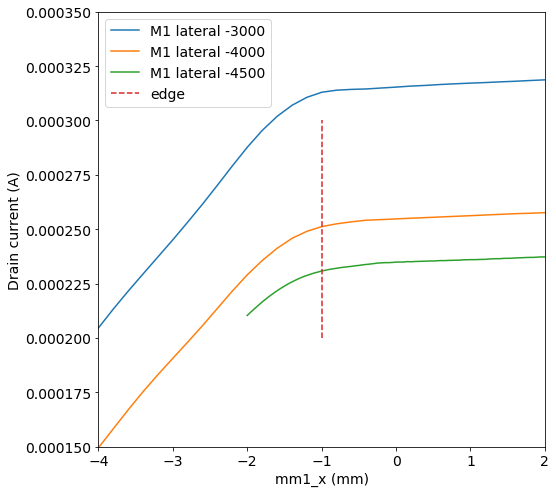

In [8]:
fig=plt.figure(figsize=[8,8])
#plt.plot(scanSet[0]['mm2_x'],scanSet[0]['drainCurrent'],label='M1 lateral 4500')
#plt.plot(scanSet[1]['mm2_x'],scanSet[1]['drainCurrent'],label='M1 lateral 0')
#plt.plot(scanSet[2]['mm2_x'],scanSet[2]['drainCurrent'],label='M1 lateral -1000')
plt.plot(scanSet[3]['mm2_x'],scanSet[3]['drainCurrent'],label='M1 lateral -3000')
plt.plot(scanSet[4]['mm2_x'],scanSet[4]['drainCurrent'],label='M1 lateral -4000')
plt.plot(scanSet[5]['mm2_x'],scanSet[5]['drainCurrent'],label='M1 lateral -4500')
knee_x = -1
plt.plot([knee_x,knee_x],[20e-5,30e-5],linestyle='--',label='edge')
plt.ylabel('Drain current (A)')
plt.xlabel('mm1_x (mm)')
plt.xlim([-4,2])
plt.ylim([15e-5,35e-5])
plt.legend()
plt.show()

I'm not sure how to sharply define the edge position, but eyeballing it gives us a result of:
- mm1_x touches the beam at +1.15
- mm2_x touches the beam at -1.00

From the point of first touching the beam, how far is it to the beam center for m1_x and mm2_x?

<img src="images/m1_1.png"/>

These dimensions are taken from Toyama's drawing of the chambers, and I assume the mid-point of each chamber. 7.5mm is what Antonio has told us.

Based on these values:

In [7]:
print("Solid angle accepted by the fixed mask is: {0:2.2e} radians".format(2* math.atan(3.5/4550)))
print("mm1_x distance from beam edge center: {0:1.2f}".format(3.5*7162/4550))
print("mm2_x distance from beam edge center: {0:1.2f}".format(3.5*7822/4550))

Solid angle accepted by the fixed mask is: 1.54e-03 radians
mm1_x distance from beam edge center: 5.51
mm2_x distance from beam edge center: 6.02


Since the limit switches prevent motion beyond about -5mm, this means that mm2_x can close to the beam center but mm1_x can only close to within 1.66mm of the center. That's an angular half-acceptance of 0.2mrad.

You can't use the same method for the y-axis, since M1 is narrow in this direction (20mm?) and you won't be able to move it up to the edge of the light cone. The edge you see in these kind of scans will therefore always correspond to the edge of the mirror and not the edge of the beam.

***
### Finding M1 lateral position

Following the discussion above, by changing M1 lateral it is possible to move M1 partially out of the beam, in both directions. So if you scan M1 lateral while watching the drain current, you should be able to identify the correct position as the one which gives the highest drain current.

Since we supposedly now know how to get a centered front-end gap, I tried this with a smallish gap first. Y axis is closed, otherwise the electrometer overloads.

This gives a very strange result. Perhaps light is being reflected off the moveable mask? Unclear.

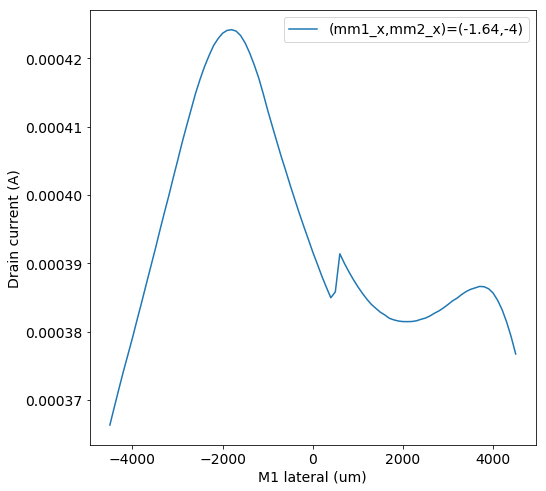

In [8]:
scan=loadScan(2507)

fig=plt.figure(figsize=[8,8])

plt.plot(scan['m1_lateral'],scan['drainCurrent'],label='(mm1_x,mm2_x)=(-1.64,-4)')
#knee_x = -1
#plt.plot([knee_x,knee_x],[20e-5,30e-5],linestyle='--',label='edge')
plt.ylabel('Drain current (A)')
plt.xlabel('M1 lateral (um)')
plt.legend()
plt.show()

So then try opening up the moveable mask a little. This gives traces more like what I was expecting, but the central position seems to not be all that constant with mask opening:

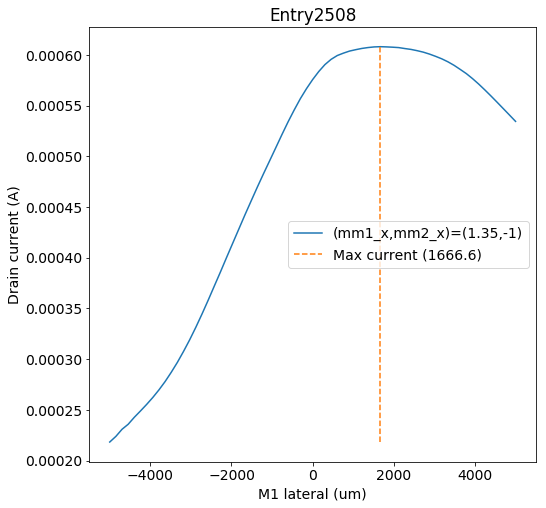

In [9]:
entryNumber=2508
scan=loadScan(entryNumber)
fig=plt.figure(figsize=[8,8])
plt.title("Entry{0}".format(entryNumber))
plt.plot(scan['m1_lateral'],scan['drainCurrent'],label='(mm1_x,mm2_x)=(1.35,-1)')
max_current_index=scan['drainCurrent'].index((max(scan['drainCurrent'])))
knee_x = scan['m1_lateral'][max_current_index]

plt.plot([knee_x,knee_x],[min(scan['drainCurrent']),max(scan['drainCurrent'])],linestyle='--',label='Max current ({0:4.1f})'.format(knee_x))
plt.ylabel('Drain current (A)')
plt.xlabel('M1 lateral (um)')
plt.legend()
plt.show()

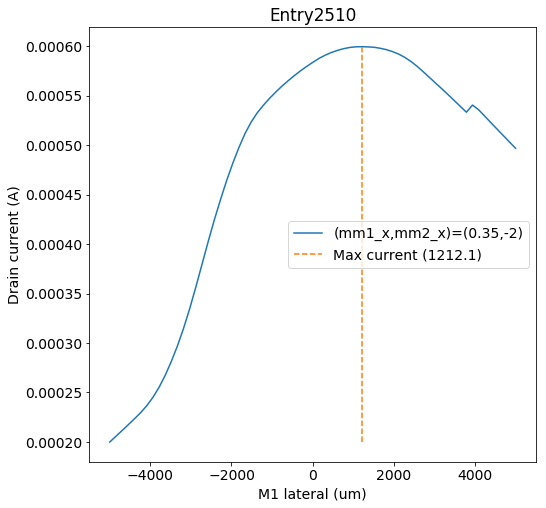

In [10]:
entryNumber=2510
scan=loadScan(entryNumber)
fig=plt.figure(figsize=[8,8])
plt.title("Entry{0}".format(entryNumber))
plt.plot(scan['m1_lateral'],scan['drainCurrent'],label='(mm1_x,mm2_x)=(0.35,-2)')
max_current_index=scan['drainCurrent'].index((max(scan['drainCurrent'])))
knee_x = scan['m1_lateral'][max_current_index]

plt.plot([knee_x,knee_x],[min(scan['drainCurrent']),max(scan['drainCurrent'])],linestyle='--',label='Max current ({0:4.1f})'.format(knee_x))
plt.ylabel('Drain current (A)')
plt.xlabel('M1 lateral (um)')
plt.legend()
plt.show()

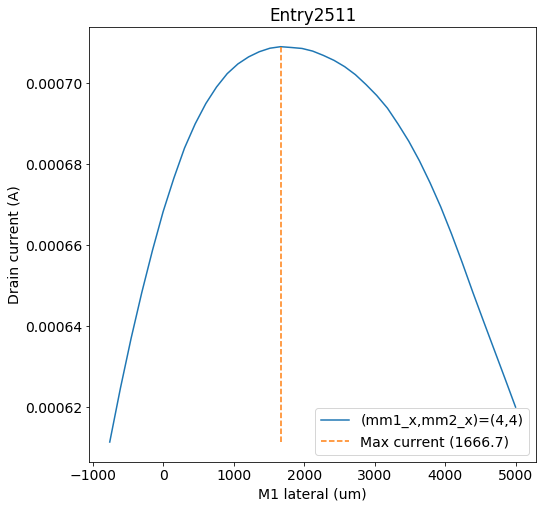

In [11]:
entryNumber=2511
scan=loadScan(entryNumber)
fig=plt.figure(figsize=[8,8])
plt.title("Entry{0}".format(entryNumber))
plt.plot(scan['m1_lateral'],scan['drainCurrent'],label='(mm1_x,mm2_x)=(4,4)')
max_current_index=scan['drainCurrent'].index((max(scan['drainCurrent'])))
knee_x = scan['m1_lateral'][max_current_index]

plt.plot([knee_x,knee_x],[min(scan['drainCurrent']),max(scan['drainCurrent'])],linestyle='--',label='Max current ({0:4.1f})'.format(knee_x))
plt.ylabel('Drain current (A)')
plt.xlabel('M1 lateral (um)')
plt.legend()
plt.show()

Does all of this depend on the M1 pitch? I let the pitch compensation feedback run (equalizing the current on the exit slit horizontal blades at 1000um gap). This wanted to bring the pitch from -1750urad to -1722urad. 

Indeed that has moved the peak in the M1 lateral scan:

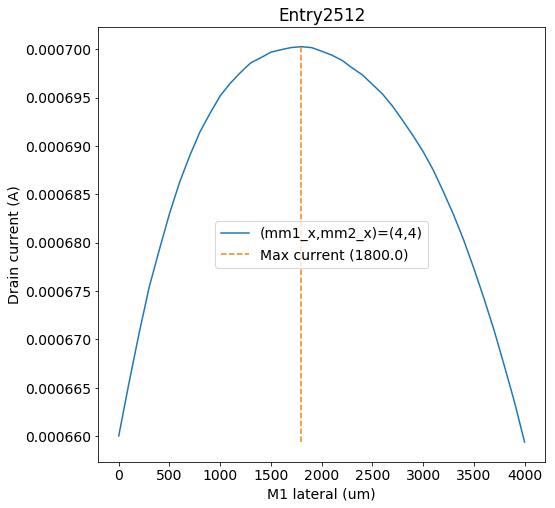

In [12]:
entryNumber=2512
scan=loadScan(entryNumber)
fig=plt.figure(figsize=[8,8])
plt.title("Entry{0}".format(entryNumber))
plt.plot(scan['m1_lateral'],scan['drainCurrent'],label='(mm1_x,mm2_x)=(4,4)')
max_current_index=scan['drainCurrent'].index((max(scan['drainCurrent'])))
knee_x = scan['m1_lateral'][max_current_index]

plt.plot([knee_x,knee_x],[min(scan['drainCurrent']),max(scan['drainCurrent'])],linestyle='--',label='Max current ({0:4.1f})'.format(knee_x))
plt.ylabel('Drain current (A)')
plt.xlabel('M1 lateral (um)')
plt.legend()
plt.show()

Unclear how to proceed with this. We have been running lately with M1 lateral of 1600, which seems in the ballpark of correct.

Perhaps if one does this iteratively (optimize M1 lat, let feedback find the right pitch, re-optimize M1 lat...) you will converge on something.

***